# MNIST Classification

## Preparation

In [1]:
from sklearn.datasets import fetch_openml
import joblib
import pandas as pd
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

In [4]:
first_image = X.iloc[0]
first_image_view = np.array(first_image).reshape(28, 28)
first_image_view

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

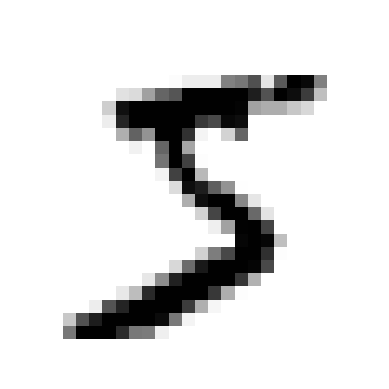

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(first_image_view, cmap="binary")
plt.axis("off")

In [6]:
y = y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Five detector

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5.head()

0     True
1    False
2    False
3    False
4    False
Name: class, dtype: bool

In [8]:
from sklearn.linear_model import SGDClassifier

# sgd_clf = SGDClassifier(random_state=42)
# sgd_clf.fit(X_train, y_train_5)
# joblib.dump(sgd_clf, "models/sgd_one_five.pkl")

sgd_clf = joblib.load("models/sgd_one_five.pkl")
# The model complain about the feature's name absence
image_df = pd.DataFrame([first_image], columns=X.columns)
sgd_clf.predict(image_df)

array([ True])

## cross_val_score customized

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    # clone_clf.fit(X_train_folds, y_train_folds)
    # joblib.dump(clone_clf, "models/sgd_own_cross.pkl")

    clone_clf = joblib.load("models/sgd_own_cross.pkl")
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.97125
0.97175
0.96785


In [10]:
from sklearn.model_selection import cross_val_score

filename = "results/cross_sgd_score.pkl"
# sgd_score = cross_val_score(sgd_clf, X_train, y_train_5,
#                             scoring="accuracy", cv=3)
# joblib.dump(sgd_score, filename)

sgd_score = joblib.load(filename)
sgd_score

array([ True, False, False, ...,  True, False, False])

In [11]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X, y=None):
        return np.zeros((len(X), 1), dtype=bool)  # Make a array-column fullfilled on zeros

In [12]:
cross_val_score(Never5Classifier(), X_train, y_train_5,
                scoring="accuracy", cv=3)

array([0.91125, 0.90855, 0.90915])

In [13]:
from sklearn.model_selection import cross_val_predict

filename = "results/sgd_cross_predict.pkl"
# y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5,
#                                  cv=3)
# joblib.dump(y_train_pred, filename)

y_train_pred = joblib.load(filename)
y_train_pred

array([ True, False, False, ...,  True, False, False])

## Confusion matrix, recall and precision

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # 3530 / (3530 + 687)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)  # 3530 / (3530 + 1891)

0.6511713705958311

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

## Checking the sgd_clf limiar 

In [19]:
y_scores = sgd_clf.decision_function(image_df)
y_scores

array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > 0)
y_some_digit_pred

array([ True])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
filename = "results/cross_sgd_decision.pkl"
# y_scores = cross_val_predict(sgd_clf, X_train, y_train_5,
#                              cv=3, method="decision_function")
# joblib.dump(y_scores, filename)

y_scores = joblib.load(filename)
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions)
print(recalls)
print(thresholds)

[0.09035    0.09035151 0.09035301 ... 1.         1.         1.        ]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00]
[-146348.56726174 -142300.00705404 -137588.97581744 ...   38871.26391927
   42216.05562787   49441.43765905]


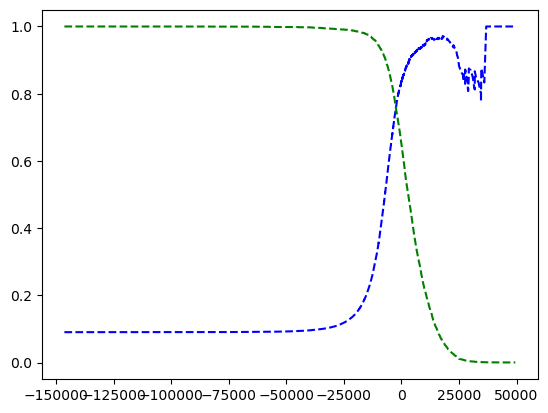

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()